# 3D Organization

In [99]:
import os
import subprocess

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pybedtools as pbt
import seaborn as sns
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

In [2]:
outdir = os.path.join(ciepy.root, 'output',
                      '3d_organization')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              '3d_organization')
cpy.makedir(private_outdir)

In [3]:
fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis',
                  'encode_stem_cell_chip_seq.tsv')
encode_chip_seq = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
t_to_g = pd.read_table(cpy.gencode_transcript_gene, index_col=0, header=None, 
                       squeeze=True)

fn = 'ftp://ftp.informatics.jax.org/pub/reports/HOM_AllOrganism.rpt'
conv = pd.read_table(fn, index_col=0, low_memory=False)
mouse_genes = conv[conv['Common Organism Name'] == 'mouse, laboratory']
human_genes = conv[conv['Common Organism Name'] == 'human']

wit_nanog = pd.read_excel(os.path.join(ciepy.root, 'private_data', 'nature12420-s3.xls'))

fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

fn = ('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/'
      'private_data/wgs/biallelic_snvs.vcf.gz')
vcf_reader = pyvcf.Reader(open(fn), compressed=True)

In [5]:
def liftover_bed(bt, chain, mapped=None, unmapped=None):
    """Lift over a bed file using a given chain file. Returns pandas data
    frame with old coordinates as index and new coordinates as columns. Regions
    that couldn't be lifted over are discarded."""
    import tempfile
    bt = bt.sort()
    mapped = tempfile.NamedTemporaryFile()
    unmapped = tempfile.NamedTemporaryFile()
    c = '{} {} {} {} {}'.format(cpy.liftOver, bt.fn, chain,
                                mapped.name, unmapped.name)
    subprocess.check_call(c, shell=True)
    with open(unmapped.name) as f:
        missing = pbt.BedTool(''.join([x for x in f.readlines()[1::2]]),
                              from_string=True)
    bt = bt.subtract(missing)
    bt_mapped = pbt.BedTool(mapped.name)
    old_loc = []
    for r in bt:
        old_loc.append('{}:{}-{}'.format(r.chrom, r.start, r.end))
    new_loc = []
    new_chrom = []
    new_start = []
    new_end = []
    for r in bt_mapped:
        new_loc.append('{}:{}-{}'.format(r.chrom, r.start, r.end))
        new_chrom.append(r.chrom)
        new_start.append(r.start)
        new_end.append(r.end)
    new_info = pd.DataFrame({'loc':new_loc, 
                             'chrom': new_chrom, 
                             'start': new_start,
                             'end': new_end}, 
                            index=old_loc)
    mapped.close()
    unmapped.close()
    return new_info

In [ ]:
mouse_genes['symbol_upper'] = mouse_genes['Symbol'].apply(lambda x: x.upper())
mouse_genes.ix[mouse_genes.Synonyms.isnull() == False, 'synonyms_list'] = \
    mouse_genes.ix[mouse_genes.Synonyms.isnull() == False, 
                   'Synonyms'].apply(lambda x: [y.upper() for y in x.split('|')])
syns = set([item for sublist in mouse_genes.synonyms_list.dropna().values for item in sublist])
synonyms_list = mouse_genes.ix[mouse_genes.synonyms_list.isnull() == False, 'synonyms_list']

## *NANOG Trans* Associations

In [ ]:
wit_bt = pbt.BedTool('\n'.join(wit_nanog.chromosome + '\t' + 
                               wit_nanog.start.astype(str) + 
                               '\t' + wit_nanog.end.astype(str)) + '\n',
                     from_string=True)

In [7]:
wit_nanog['human_gene_name'] = np.nan
wit_nanog['HomoloGene ID'] = np.nan
for i in wit_nanog.index:
    g = wit_nanog.ix[i, 'associated gene'].upper()
    t = mouse_genes[mouse_genes.symbol_upper == g]
    if t.shape[0] == 0:
        if g in syns:
            t = synonyms_list[synonyms_list.apply(lambda x: g in x)]
    if t.shape[0] == 1:
        if t.index[0] in human_genes.index.values:
            wit_nanog.ix[i, 'HomoloGene ID'] = t.index[0]
            ht = human_genes.ix[t.index[0], 'Symbol']
            if type(ht) == str:
                wit_nanog.ix[i, 'human_gene_name'] = ht
            else:
                wit_nanog.ix[i, 'human_gene_name'] = '|'.join(ht.values)

In [8]:
wit_nanog['human_gene_id'] = np.nan
for i in wit_nanog.human_gene_name.dropna().index:
    t = gene_info[gene_info.gene_name == wit_nanog.ix[i, 'human_gene_name']]
    if t.shape[0] == 1:
        wit_nanog.ix[i, 'human_gene_id'] = t.index[0]
    elif t.shape[0] == 0:
        t = gene_info[gene_info.gene_name.apply(lambda x: x.upper()) == 
                      wit_nanog.ix[i, 'human_gene_name'].upper()]

In [9]:
# I can go to 100000. Most local QTLs are closer than that.
tss = pbt.BedTool(cpy.gencode_tss_bed)
tss_2kb = tss.slop(l=2000, r=2000, g=pbt.genome_registry.hg19).merge()
tss_intersect = tss_2kb.intersect(tss, wo=True, sorted=True)

genes_to_tss = {}
for r in tss_intersect:
    g = t_to_g[r.fields[6].split('_')[0]]
    genes_to_tss[g] = genes_to_tss.get(g, set()) | set(['{}:{}-{}'.format(r.chrom, r.start, r.end)])
genes_to_tss = pd.Series(genes_to_tss)

In [11]:
gene_id = gene_info[gene_info.gene_name == 'NANOG'].index[0]
toutdir = os.path.join(outdir, 'wit_nanog_trans')

if not os.path.exists(toutdir):
    os.chdir('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/notebooks')
    cpy.makedir(toutdir)
    fn = os.path.join(toutdir, 'wit_nanog_trans.sh')
    with open(fn, 'w') as f:
        c = 'python {} \\\n\t'.format(os.path.join(ciepy.root, 'scripts', 'run_emmax.py'))
        c += ' \\\n\t'.join([
                gene_id,
                os.path.join(ciepy.root, 'private_data', 'wgs', 'biallelic_snvs.vcf.gz'),
                ','.join(reduce(lambda x,y: x | y, genes_to_tss[wit_nanog.human_gene_id.dropna()])),
                os.path.join(ciepy.root, 'output', 'eqtl_input', 
                             'tpm_log_filtered_phe_std_norm_peer_resid.tsv'),
                os.path.join(ciepy.root, 'output', 'eqtl_input', 'emmax.ind'),
                os.path.join(ciepy.root, 'output', 'eqtl_input', 'wgs.kin'),
                toutdir,
                '-c {}'.format(os.path.join(ciepy.root, 'output', 'eqtl_input', 
                                            'emmax_sex_only.cov')),
                '-i 10000 -a 20000'
            ])
        f.write(c + '\n')
    subprocess.check_call('bash {}'.format(fn), shell=True)

In [160]:
res = ciepy.read_emmax_output(os.path.join(toutdir, '{}.tsv'.format(gene_id)))
res = res.sort(columns=['PVALUE'])
min_pvals = pd.read_table(os.path.join(toutdir, 'minimum_pvalues.tsv'),                            
                          header=None, squeeze=True)
p = (1 + sum(min_pvals <= res.PVALUE.min())) / float(min_pvals.shape[0] + 1)

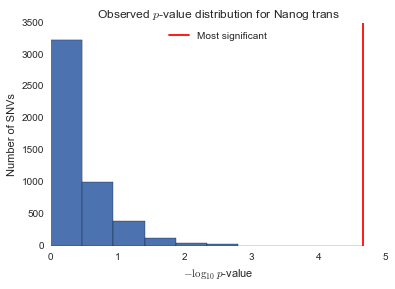

In [162]:
(-np.log10(res.PVALUE)).hist()
ya, yb = plt.ylim()
plt.vlines(-np.log10(res.PVALUE.min()), ya, yb,
           color='red', label='Most significant')
plt.legend(loc='upper center')
plt.title('Observed $p$-value distribution for Nanog trans')
plt.xlabel('$-\log_{10}$ $p$-value')
plt.ylabel('Number of SNVs');

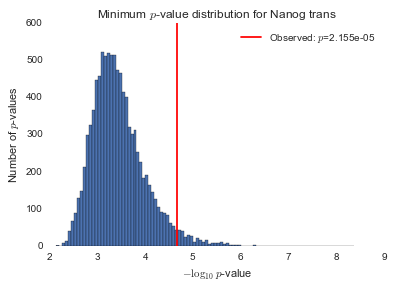

In [163]:
fig, ax = plt.subplots(1, 1)
ax = (-np.log10(min_pvals)).hist(bins=100, ax=ax)
ax.set_ylabel('Number of $p$-values')
ax.set_xlabel('$-\log_{10}$ $p$-value')
ya, yb = ax.get_ylim()
ax.vlines(-np.log10(res.PVALUE.min()), ya, yb, colors=['red'], 
          label='Observed: $p$={}'.format(res.PVALUE.min()))
ax.legend()
ax.set_title('Minimum $p$-value distribution for Nanog trans');

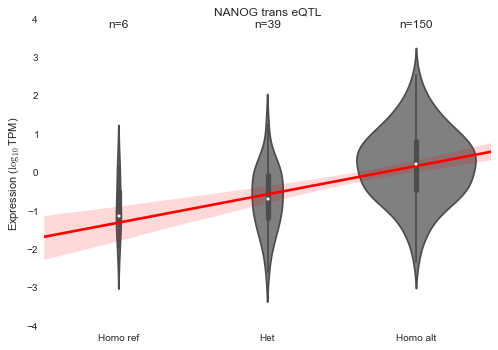

In [199]:
t =  vcf_reader.fetch('chr{}'.format(res.CHROM.values[0]), 
                      res.BEG.values[0], res.BEG.values[0] + 1)
r = t.next()
tdf = pd.DataFrame(exp.ix[gene_id])
tdf.columns = ['expression']
tdf['genotype'] = 0
hets = set(exp.columns) & set([s.sample for s in r.get_hets()])
tdf.ix[hets, 'genotype'] = 1
alts = set(exp.columns) & set([s.sample for s in r.get_hom_alts()])
tdf.ix[alts, 'genotype'] = 2
plt.figure()
ax = sns.violinplot(x='genotype', y='expression', data=tdf, color='grey',
                order=[0, 1, 2], scale='count')
ax = sns.regplot(x='genotype', y='expression', data=tdf, scatter=False, color='red')
ax.set_xticklabels(['Homo ref', 'Het', 'Homo alt'])
ax.set_ylabel('Expression ($\log_{10}$ TPM)')
ax.set_xlabel('')
ya, yb = plt.ylim()
plt.text(0, yb, 'n={}'.format(sum(tdf.genotype == 0)), 
         verticalalignment='top', horizontalalignment='center', fontsize=12)
plt.text(1, yb, 'n={}'.format(sum(tdf.genotype == 1)), 
         verticalalignment='top', horizontalalignment='center', fontsize=12)
plt.text(2, yb, 'n={}'.format(sum(tdf.genotype == 2)), 
         verticalalignment='top', horizontalalignment='center', fontsize=12)
plt.title('{} trans eQTL'.format(gene_info.ix[gene_id, 'gene_name']));
plt.savefig(os.path.join(outdir, 'nanog_trans_eqtl.pdf'));

This appears to be a *trans* eQTL for *NANOG*. The variant lies in a
weak enhancer region in H1-hESCs (chr16:90,102,249-90,102,518) that 
is mainly marked by H3K4me1 and is in the intron of the *GAS8* gene.

In [50]:
sig_bt = pbt.BedTool('chr{}\t{}\t{}\n'.format(res.CHROM[0], res.BEG[0] - 1, res.END[0]), 
                     from_string=True)
overlap = pd.Series(False, index=encode_chip_seq.target)
for i in encode_chip_seq.index:
    c = encode_chip_seq.ix[i, 'target']
    bt = pbt.BedTool(cpb.general.read_gzipped_text_url(encode_chip_seq.ix[i, 'narrowPeak_url']), 
                     from_string=True)
    bt = bt.sort()
    inter = sig_bt.intersect(bt, sorted=True, wo=True)
    if len(inter) > 0:
        overlap[c] = True

### Nearby SNVs

I'd like to look at other SNVs near this one that appears to have a significant
trans association to see whether any others are more strongly associated. 

In [124]:
gene_id = gene_info[gene_info.gene_name == 'NANOG'].index[0]
toutdir = os.path.join(outdir, 'nanog_gas8')

if not os.path.exists(toutdir):
    t = tss.slop(l=1000000, r=1000000, g=pbt.genome_registry.hg19).merge()
    res = t.intersect(tss, wo=True, sorted=True)
    t = {}
    for r in res:
        g = t_to_g[r.fields[6].split('_')[0]]
        t[g] = t.get(g, set()) | set(['{}:{}-{}'.format(r.chrom, r.start, r.end)])
    t = pd.Series(t)
    
    os.chdir('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/notebooks')
    cpy.makedir(toutdir)
    fn = os.path.join(toutdir, 'nanog_gas8.sh')
    with open(fn, 'w') as f:
        c = 'python {} \\\n\t'.format(os.path.join(ciepy.root, 'scripts', 'run_emmax.py'))
        c += ' \\\n\t'.join([
                gene_id,
                os.path.join(ciepy.root, 'private_data', 'wgs', 'biallelic_snvs.vcf.gz'),
                ','.join(t[gene_info[gene_info.gene_name == 'GAS8'].index[0]]),
                os.path.join(ciepy.root, 'output', 'eqtl_input', 
                             'tpm_log_filtered_phe_std_norm_peer_resid.tsv'),
                os.path.join(ciepy.root, 'output', 'eqtl_input', 'emmax.ind'),
                os.path.join(ciepy.root, 'output', 'eqtl_input', 'wgs.kin'),
                toutdir,
                '-c {}'.format(os.path.join(ciepy.root, 'output', 'eqtl_input', 
                                            'emmax_sex_only.cov')),
            ])
        f.write(c + '\n')
    subprocess.check_call('bash {}'.format(fn), shell=True)

In [143]:
gas8_res = ciepy.read_emmax_output(os.path.join(toutdir, '{}.tsv'.format(gene_id)))
gas8_res = gas8_res.sort(columns=['PVALUE'])
gas8_min_pvals = pd.read_table(os.path.join(toutdir, 'minimum_pvalues.tsv'),                            
                               header=None, squeeze=True)
gas8_p = (1 + sum(gas8_min_pvals <= gas8_res.PVALUE.min())) / float(gas8_min_pvals.shape[0] + 1)

In [144]:
gas8_p

0.31368631368631367

In [137]:
gas8_res = ciepy.read_emmax_output(os.path.join(toutdir, '{}.tsv'.format(gene_id)))
gas8_res = gas8_res.sort(columns=['PVALUE'])

In [166]:
res.index = ('chr' + res.CHROM.astype(str) + ':' + 
             res.BEG.astype(str) + '-' + res.END.astype(str))
gas8_res.index = ('chr' + gas8_res.CHROM.astype(str) + ':' + 
                  gas8_res.BEG.astype(str) + '-' + gas8_res.END.astype(str))

In [167]:
shared = set(res.index) & set(gas8_res.index)
not_shared = set(gas8_res.index) - shared

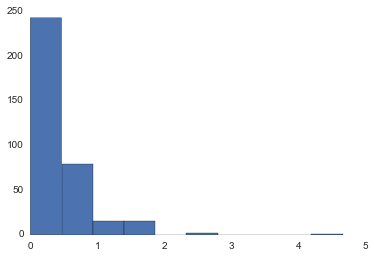

In [170]:
(-np.log10(gas8_res.ix[shared, 'PVALUE'])).hist()

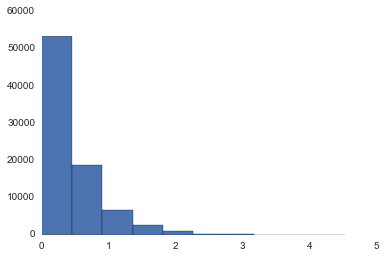

In [171]:
(-np.log10(gas8_res.ix[not_shared, 'PVALUE'])).hist()

### Interaction Database

I want to see if there is any evidence of an interaction between this 
gene/enhancer and Nanog according to data from the interaction database.

In [56]:
fn = '/raid2/projects/chromatin_interactions/downloaded/4DGenome/4DGenome_HomoSapiens_hg19.txt'
inter_db = pd.read_table(fn, low_memory=False)

In [80]:
s = '\n'.join(inter_db.InteractorAChr + '\t' + inter_db.InteractorAStart.astype(str) + 
              '\t' + inter_db.InteractorAEnd.astype(str) + '\t' + 
              inter_db.InteractorBChr + ':' + inter_db.InteractorBStart.astype(str) + 
              '-' + inter_db.InteractorBEnd.astype(str)) + '\n'
abt = pbt.BedTool(s, from_string=True)

s = '\n'.join(inter_db.InteractorBChr + '\t' + inter_db.InteractorBStart.astype(str) + 
              '\t' + inter_db.InteractorBEnd.astype(str) + '\t' + 
              inter_db.InteractorAChr + ':' + inter_db.InteractorAStart.astype(str) + 
              '-' + inter_db.InteractorAEnd.astype(str)) + '\n'
bbt = pbt.BedTool(s, from_string=True)

chrom, start, end = gene_info.ix[gene_info.gene_name == 'NANOG', ['chrom', 'start', 'end']].values[0]
nanog_bt = pbt.BedTool('{}\t{}\t{}\n'.format(chrom, start, end), from_string=True)
resa = nanog_bt.intersect(abt, wo=True)
resb = nanog_bt.intersect(bbt, wo=True)

In [100]:
print(resa)

chr12	7940389	7948655	chr12	7942001	7944001	chr12:7899118-7901118	2000
chr12	7940389	7948655	chr12	7942001	7944001	chr12:7899118-7901118	2000
chr12	7940389	7948655	chr12	7942001	7944001	chr12:7952063-7954063	2000
chr12	7940389	7948655	chr12	7942001	7944001	chr12:7952063-7954063	2000
chr12	7940389	7948655	chr12	7942001	7944001	chr12:8002414-8004414	2000
chr12	7940389	7948655	chr12	7942001	7944001	chr12:8002414-8004414	2000
chr12	7940389	7948655	chr12	7942001	7944001	chr12:8024420-8026420	2000
chr12	7940389	7948655	chr12	7942001	7944001	chr12:8024420-8026420	2000
chr12	7940389	7948655	chr12	7942001	7944001	chr12:8233807-8235807	2000
chr12	7940389	7948655	chr12	7942201	7944201	chr12:7899118-7901118	2000
chr12	7940389	7948655	chr12	7942201	7944201	chr12:7925148-7927148	2000
chr12	7940389	7948655	chr12	7942201	7944201	chr12:7952063-7954063	2000
chr12	7940389	7948655	chr12	7942201	7944201	chr12:8233807-8235807	2000



In [101]:
print(resb)

chr12	7940389	7948655	chr12	7940992	7942992	chr12:7789801-7791801	2000
chr12	7940389	7948655	chr12	7940992	7942992	chr12:7949601-7951601	2000
chr12	7940389	7948655	chr12	7940992	7942992	chr12:8042401-8044401	2000
chr12	7940389	7948655	chr12	7940992	7942992	chr12:8042401-8044401	2000
chr12	7940389	7948655	chr12	7940992	7942992	chr12:8057401-8059401	2000
chr12	7940389	7948655	chr12	7940992	7942992	chr12:8086201-8088201	2000
chr12	7940389	7948655	chr12	7940992	7942992	chr12:8112801-8114801	2000
chr12	7940389	7948655	chr12	7940992	7942992	chr12:8189801-8191801	2000
chr12	7940389	7948655	chr12	7940992	7942992	chr12:8190001-8192001	2000
chr12	7940389	7948655	chr12	7940992	7942992	chr12:8190001-8192001	2000
chr12	7940389	7948655	chr12	7940992	7942992	chr12:8190001-8192001	2000
chr12	7940389	7948655	chr12	7940992	7942992	chr12:8190001-8192001	2000
chr12	7940389	7948655	chr12	7940992	7942992	chr12:8190201-8192201	2000
chr12	7940389	7948655	chr12	7940992	7942992	chr12:8190201-8192201	2000
chr12	